# Transformer Basics: Attention Is All You Need

## Introduction

The Transformer architecture, introduced by Vaswani et al. (2017), revolutionized sequence-to-sequence modeling by replacing recurrent mechanisms entirely with attention mechanisms. This notebook provides a rigorous introduction to the core mathematical concepts underlying Transformers.

## 1. Self-Attention Mechanism

The fundamental operation in a Transformer is **scaled dot-product attention**. Given input sequences represented as matrices, we compute three projections:

- **Query**: $Q = XW^Q$
- **Key**: $K = XW^K$
- **Value**: $V = XW^V$

where $X \in \mathbb{R}^{n \times d_{\text{model}}}$ is the input matrix with $n$ tokens and embedding dimension $d_{\text{model}}$, and $W^Q, W^K, W^V \in \mathbb{R}^{d_{\text{model}} \times d_k}$ are learnable weight matrices.

### Scaled Dot-Product Attention

The attention function is computed as:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The scaling factor $\sqrt{d_k}$ prevents the dot products from growing too large in magnitude, which would push the softmax into regions with extremely small gradients.

### Why Scaling Matters

For large values of $d_k$, the dot products $q \cdot k$ can have large variance. Assuming $q$ and $k$ are vectors with components drawn from a distribution with mean 0 and variance 1, their dot product has:

$$\mathbb{E}[q \cdot k] = 0, \quad \text{Var}(q \cdot k) = d_k$$

Dividing by $\sqrt{d_k}$ normalizes the variance to 1.

## 2. Multi-Head Attention

Instead of performing a single attention function, we linearly project the queries, keys, and values $h$ times with different learned projections:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O$$

where each head is computed as:

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

with $W_i^Q, W_i^K, W_i^V \in \mathbb{R}^{d_{\text{model}} \times d_k}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.

Typically, $d_k = d_v = d_{\text{model}}/h$, so the computational cost is similar to single-head attention.

## 3. Positional Encoding

Since the Transformer contains no recurrence, we must inject positional information. The original paper uses sinusoidal positional encodings:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

where $pos$ is the position and $i$ is the dimension index. This encoding allows the model to learn relative positions since:

$$PE_{pos+k} = f(PE_{pos})$$

can be represented as a linear function of $PE_{pos}$.

## 4. Feed-Forward Network

Each Transformer layer includes a position-wise feed-forward network:

$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

This is applied to each position separately and identically, with inner dimension $d_{ff}$ (typically $4 \times d_{\text{model}}$).

## 5. Layer Normalization and Residual Connections

Each sub-layer (attention and FFN) is wrapped with:

$$\text{LayerNorm}(x + \text{Sublayer}(x))$$

Layer normalization normalizes across features:

$$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sigma + \epsilon} + \beta$$

where $\mu$ and $\sigma$ are the mean and standard deviation computed across the last dimension.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

# Set random seed for reproducibility
np.random.seed(42)

# Hyperparameters
d_model = 64      # Model dimension
d_k = 16          # Key/Query dimension
d_v = 16          # Value dimension
n_heads = 4       # Number of attention heads
seq_len = 10      # Sequence length
d_ff = 256        # Feed-forward inner dimension

print("Transformer Configuration:")
print(f"  Model dimension (d_model): {d_model}")
print(f"  Key/Query dimension (d_k): {d_k}")
print(f"  Value dimension (d_v): {d_v}")
print(f"  Number of heads: {n_heads}")
print(f"  Sequence length: {seq_len}")
print(f"  Feed-forward dimension: {d_ff}")

Transformer Configuration:
  Model dimension (d_model): 64
  Key/Query dimension (d_k): 16
  Value dimension (d_v): 16
  Number of heads: 4
  Sequence length: 10
  Feed-forward dimension: 256


In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        Q: Query matrix of shape (seq_len, d_k)
        K: Key matrix of shape (seq_len, d_k)
        V: Value matrix of shape (seq_len, d_v)
        mask: Optional mask for causal attention
    
    Returns:
        output: Attention output of shape (seq_len, d_v)
        attention_weights: Attention weights of shape (seq_len, seq_len)
    """
    d_k = Q.shape[-1]
    
    # Compute attention scores: QK^T / sqrt(d_k)
    scores = np.matmul(Q, K.T) / np.sqrt(d_k)
    
    # Apply mask if provided (for causal attention)
    if mask is not None:
        scores = np.where(mask == 0, -1e9, scores)
    
    # Apply softmax to get attention weights
    attention_weights = softmax(scores, axis=-1)
    
    # Compute output
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

# Test scaled dot-product attention
Q_test = np.random.randn(seq_len, d_k)
K_test = np.random.randn(seq_len, d_k)
V_test = np.random.randn(seq_len, d_v)

output, attn_weights = scaled_dot_product_attention(Q_test, K_test, V_test)
print(f"Input Q shape: {Q_test.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"\nAttention weights sum per row (should be 1.0): {attn_weights.sum(axis=-1)}")

Input Q shape: (10, 16)
Output shape: (10, 16)
Attention weights shape: (10, 10)

Attention weights sum per row (should be 1.0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [3]:
class MultiHeadAttention:
    """
    Multi-Head Attention mechanism.
    """
    def __init__(self, d_model, n_heads, d_k, d_v):
        self.n_heads = n_heads
        self.d_k = d_k
        self.d_v = d_v
        
        # Initialize projection weights
        self.W_Q = [np.random.randn(d_model, d_k) * 0.1 for _ in range(n_heads)]
        self.W_K = [np.random.randn(d_model, d_k) * 0.1 for _ in range(n_heads)]
        self.W_V = [np.random.randn(d_model, d_v) * 0.1 for _ in range(n_heads)]
        self.W_O = np.random.randn(n_heads * d_v, d_model) * 0.1
    
    def forward(self, X, mask=None):
        """
        Forward pass of multi-head attention.
        
        Args:
            X: Input of shape (seq_len, d_model)
            mask: Optional attention mask
        
        Returns:
            output: Output of shape (seq_len, d_model)
            attention_weights: List of attention weights for each head
        """
        heads = []
        attention_weights_all = []
        
        for i in range(self.n_heads):
            # Project to Q, K, V
            Q = np.matmul(X, self.W_Q[i])
            K = np.matmul(X, self.W_K[i])
            V = np.matmul(X, self.W_V[i])
            
            # Compute attention
            head_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
            heads.append(head_output)
            attention_weights_all.append(attn_weights)
        
        # Concatenate heads
        concat_heads = np.concatenate(heads, axis=-1)
        
        # Final projection
        output = np.matmul(concat_heads, self.W_O)
        
        return output, attention_weights_all

# Test multi-head attention
mha = MultiHeadAttention(d_model, n_heads, d_k, d_v)
X_test = np.random.randn(seq_len, d_model)
output, attn_weights_list = mha.forward(X_test)

print(f"Input shape: {X_test.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of attention heads: {len(attn_weights_list)}")
print(f"Each head's attention weights shape: {attn_weights_list[0].shape}")

Input shape: (10, 64)
Output shape: (10, 64)
Number of attention heads: 4
Each head's attention weights shape: (10, 10)


In [4]:
def positional_encoding(seq_len, d_model):
    """
    Generate sinusoidal positional encodings.
    
    Args:
        seq_len: Length of sequence
        d_model: Model dimension
    
    Returns:
        PE: Positional encoding matrix of shape (seq_len, d_model)
    """
    PE = np.zeros((seq_len, d_model))
    
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            # Compute the angle
            angle = pos / (10000 ** (i / d_model))
            
            # Apply sin to even indices
            PE[pos, i] = np.sin(angle)
            
            # Apply cos to odd indices
            if i + 1 < d_model:
                PE[pos, i + 1] = np.cos(angle)
    
    return PE

# Generate positional encodings
PE = positional_encoding(seq_len, d_model)
print(f"Positional encoding shape: {PE.shape}")
print(f"\nFirst position encoding (first 8 dims): {PE[0, :8]}")
print(f"Second position encoding (first 8 dims): {PE[1, :8]}")

Positional encoding shape: (10, 64)

First position encoding (first 8 dims): [0. 1. 0. 1. 0. 1. 0. 1.]
Second position encoding (first 8 dims): [0.84147098 0.54030231 0.68156135 0.73176098 0.53316844 0.84600911
 0.40930892 0.91239586]


In [5]:
def layer_norm(x, gamma=None, beta=None, eps=1e-6):
    """
    Apply layer normalization.
    
    Args:
        x: Input of shape (..., d_model)
        gamma: Scale parameter
        beta: Shift parameter
        eps: Small constant for numerical stability
    
    Returns:
        Normalized output
    """
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    
    x_norm = (x - mean) / (std + eps)
    
    if gamma is not None and beta is not None:
        x_norm = gamma * x_norm + beta
    
    return x_norm

def feed_forward_network(x, W1, b1, W2, b2):
    """
    Position-wise feed-forward network.
    
    Args:
        x: Input of shape (seq_len, d_model)
        W1, b1: First layer weights and bias
        W2, b2: Second layer weights and bias
    
    Returns:
        Output of shape (seq_len, d_model)
    """
    # First linear layer with ReLU
    hidden = np.maximum(0, np.matmul(x, W1) + b1)
    
    # Second linear layer
    output = np.matmul(hidden, W2) + b2
    
    return output

# Test layer norm
x_test = np.random.randn(seq_len, d_model) * 10 + 5
x_norm = layer_norm(x_test)
print(f"Before LayerNorm - Mean: {x_test.mean(axis=-1).mean():.4f}, Std: {x_test.std(axis=-1).mean():.4f}")
print(f"After LayerNorm - Mean: {x_norm.mean(axis=-1).mean():.4f}, Std: {x_norm.std(axis=-1).mean():.4f}")

Before LayerNorm - Mean: 5.3091, Std: 9.8988
After LayerNorm - Mean: 0.0000, Std: 1.0000


In [6]:
class TransformerEncoderLayer:
    """
    Single Transformer Encoder Layer.
    """
    def __init__(self, d_model, n_heads, d_k, d_v, d_ff):
        self.mha = MultiHeadAttention(d_model, n_heads, d_k, d_v)
        
        # Feed-forward network weights
        self.W1 = np.random.randn(d_model, d_ff) * 0.1
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model) * 0.1
        self.b2 = np.zeros(d_model)
        
        # Layer norm parameters
        self.gamma1 = np.ones(d_model)
        self.beta1 = np.zeros(d_model)
        self.gamma2 = np.ones(d_model)
        self.beta2 = np.zeros(d_model)
    
    def forward(self, X):
        """
        Forward pass of encoder layer.
        
        Args:
            X: Input of shape (seq_len, d_model)
        
        Returns:
            output: Output of shape (seq_len, d_model)
            attention_weights: Attention weights from MHA
        """
        # Multi-head attention with residual connection and layer norm
        attn_output, attention_weights = self.mha.forward(X)
        X = layer_norm(X + attn_output, self.gamma1, self.beta1)
        
        # Feed-forward network with residual connection and layer norm
        ff_output = feed_forward_network(X, self.W1, self.b1, self.W2, self.b2)
        output = layer_norm(X + ff_output, self.gamma2, self.beta2)
        
        return output, attention_weights

# Test encoder layer
encoder_layer = TransformerEncoderLayer(d_model, n_heads, d_k, d_v, d_ff)
X_test = np.random.randn(seq_len, d_model)
output, attn_weights = encoder_layer.forward(X_test)

print(f"Input shape: {X_test.shape}")
print(f"Output shape: {output.shape}")
print(f"Output mean: {output.mean():.4f}")
print(f"Output std: {output.std():.4f}")

Input shape: (10, 64)
Output shape: (10, 64)
Output mean: 0.0000
Output std: 1.0000


In [7]:
# Demonstrate the effect of scaling on attention distribution
print("Effect of Scaling Factor on Attention Distribution")
print("="*50)

# Generate random Q, K
Q_demo = np.random.randn(5, d_k) * np.sqrt(d_k)  # Scale up to show effect
K_demo = np.random.randn(5, d_k) * np.sqrt(d_k)

# Without scaling
scores_unscaled = np.matmul(Q_demo, K_demo.T)
attn_unscaled = softmax(scores_unscaled, axis=-1)

# With scaling
scores_scaled = scores_unscaled / np.sqrt(d_k)
attn_scaled = softmax(scores_scaled, axis=-1)

print(f"\nUnscaled scores range: [{scores_unscaled.min():.2f}, {scores_unscaled.max():.2f}]")
print(f"Scaled scores range: [{scores_scaled.min():.2f}, {scores_scaled.max():.2f}]")
print(f"\nUnscaled attention entropy: {-np.sum(attn_unscaled * np.log(attn_unscaled + 1e-9), axis=-1).mean():.4f}")
print(f"Scaled attention entropy: {-np.sum(attn_scaled * np.log(attn_scaled + 1e-9), axis=-1).mean():.4f}")
print("\nHigher entropy = more distributed attention (better for learning)")

Effect of Scaling Factor on Attention Distribution

Unscaled scores range: [-99.49, 41.97]
Scaled scores range: [-24.87, 10.49]

Unscaled attention entropy: 0.1319
Scaled attention entropy: 0.2842

Higher entropy = more distributed attention (better for learning)


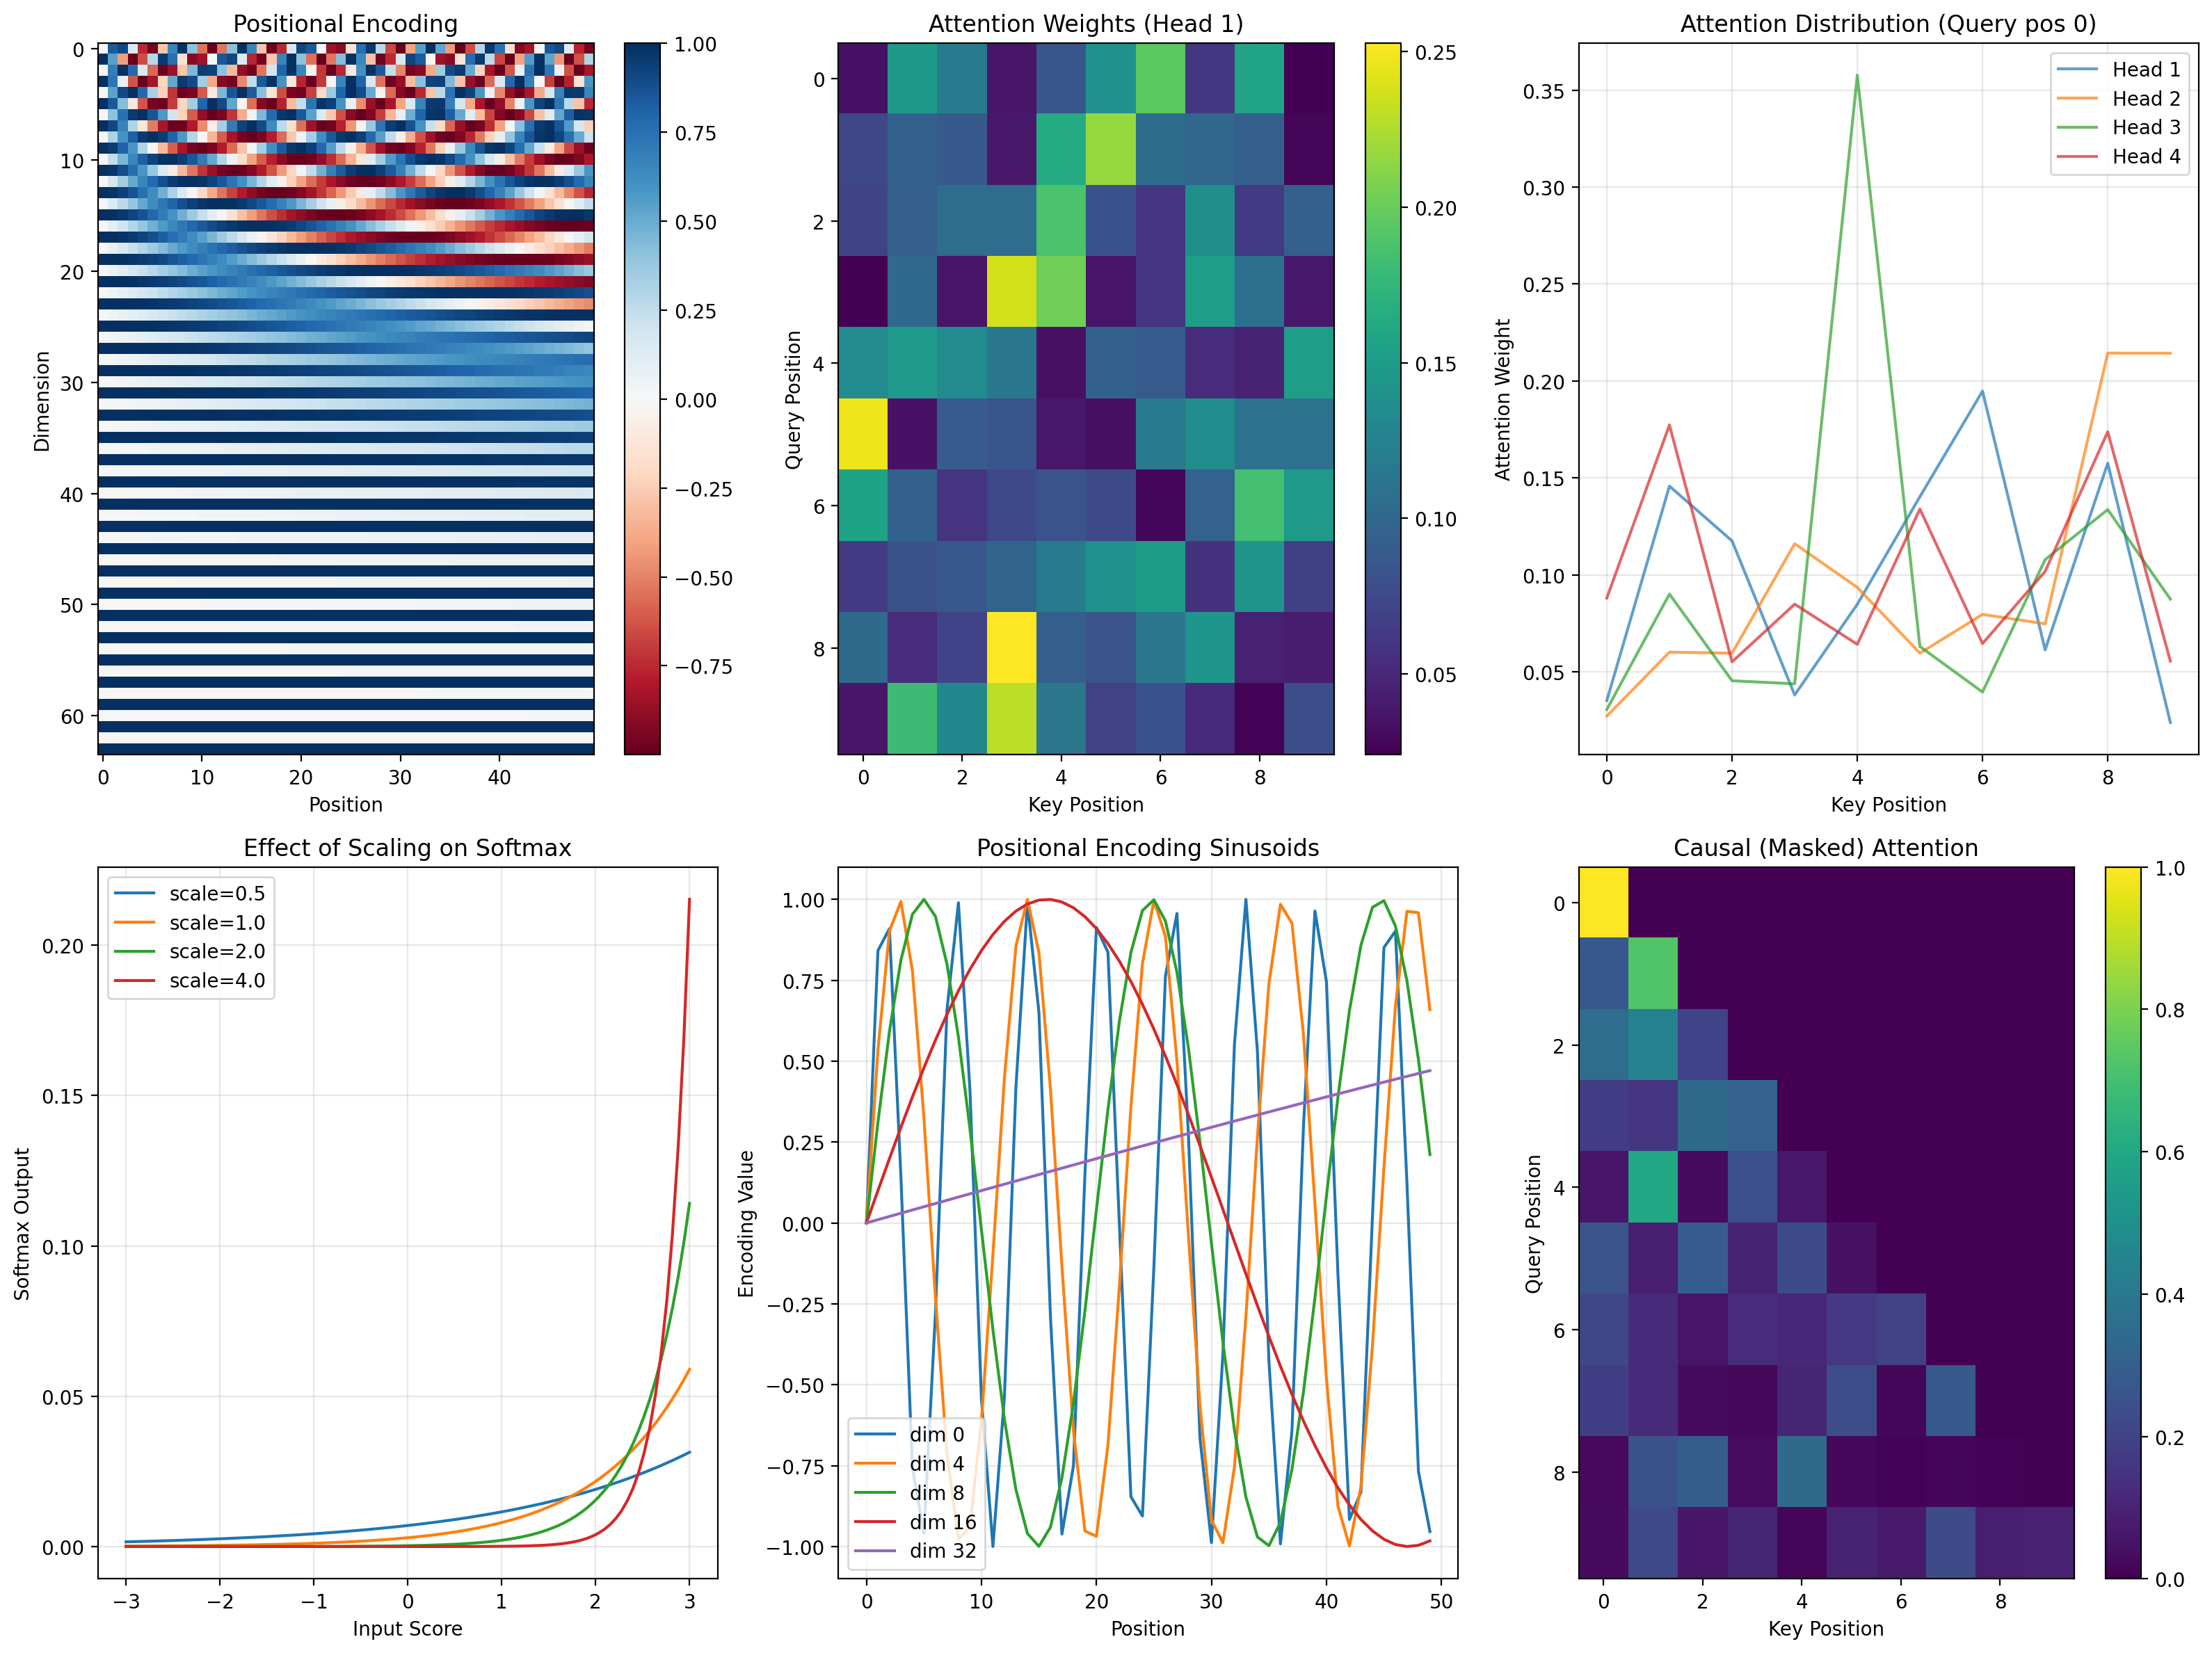


Visualization saved to plot.png


In [8]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# 1. Positional Encoding Visualization
ax1 = fig.add_subplot(2, 3, 1)
PE_vis = positional_encoding(50, d_model)
im1 = ax1.imshow(PE_vis.T, aspect='auto', cmap='RdBu')
ax1.set_xlabel('Position')
ax1.set_ylabel('Dimension')
ax1.set_title('Positional Encoding')
plt.colorbar(im1, ax=ax1)

# 2. Attention Weights Heatmap
ax2 = fig.add_subplot(2, 3, 2)
im2 = ax2.imshow(attn_weights_list[0], cmap='viridis', aspect='auto')
ax2.set_xlabel('Key Position')
ax2.set_ylabel('Query Position')
ax2.set_title('Attention Weights (Head 1)')
plt.colorbar(im2, ax=ax2)

# 3. Multi-head Attention Comparison
ax3 = fig.add_subplot(2, 3, 3)
for i, weights in enumerate(attn_weights_list):
    ax3.plot(weights[0, :], label=f'Head {i+1}', alpha=0.7)
ax3.set_xlabel('Key Position')
ax3.set_ylabel('Attention Weight')
ax3.set_title('Attention Distribution (Query pos 0)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Scaling Effect on Softmax
ax4 = fig.add_subplot(2, 3, 4)
x_range = np.linspace(-3, 3, 100)
for scale in [0.5, 1.0, 2.0, 4.0]:
    y = softmax(x_range * scale)
    ax4.plot(x_range, y, label=f'scale={scale}')
ax4.set_xlabel('Input Score')
ax4.set_ylabel('Softmax Output')
ax4.set_title('Effect of Scaling on Softmax')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Positional Encoding Sinusoids
ax5 = fig.add_subplot(2, 3, 5)
positions = np.arange(50)
for i in [0, 4, 8, 16, 32]:
    if i < d_model:
        ax5.plot(positions, PE_vis[:, i], label=f'dim {i}')
ax5.set_xlabel('Position')
ax5.set_ylabel('Encoding Value')
ax5.set_title('Positional Encoding Sinusoids')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Causal Mask Visualization
ax6 = fig.add_subplot(2, 3, 6)
causal_mask = np.tril(np.ones((seq_len, seq_len)))
Q_causal = np.random.randn(seq_len, d_k)
K_causal = np.random.randn(seq_len, d_k)
V_causal = np.random.randn(seq_len, d_v)
_, attn_causal = scaled_dot_product_attention(Q_causal, K_causal, V_causal, causal_mask)
im6 = ax6.imshow(attn_causal, cmap='viridis', aspect='auto')
ax6.set_xlabel('Key Position')
ax6.set_ylabel('Query Position')
ax6.set_title('Causal (Masked) Attention')
plt.colorbar(im6, ax=ax6)

plt.tight_layout()
plt.savefig('transformer_basics_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to plot.png")

## Summary

This notebook has demonstrated the core components of the Transformer architecture:

1. **Scaled Dot-Product Attention**: The fundamental attention mechanism that computes weighted sums of values based on query-key compatibility.

2. **Multi-Head Attention**: Allows the model to jointly attend to information from different representation subspaces at different positions.

3. **Positional Encoding**: Sinusoidal functions that inject position information into the model without using recurrence.

4. **Layer Normalization**: Stabilizes training by normalizing activations across features.

5. **Feed-Forward Networks**: Position-wise fully connected layers that process each position independently.

### Key Equations

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O$$

### References

- Vaswani, A., et al. (2017). "Attention Is All You Need." *Advances in Neural Information Processing Systems*.
- Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016). "Layer Normalization." *arXiv preprint arXiv:1607.06450*.